# Supervised Shallow Machine Learning: Support Vector Regression

<div class="alert alert-info" role="alert" 
     style="font-size: 1.2em; padding: 10px; margin: 10px 0; text-align: center;">
    
     SVR predicts continuous outcomes by finding an optimal hyperplane that minimizes errors within a 
     defined margin, capturing linear and nonlinear relationships through kernel functions.
<div>

### Import Libraries including from `sklearn` for shallow ML

In [1]:
# Data Wrangling
import glob
import pandas as pd
import numpy as np

# Machine Learn
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import shap

# Data Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#ignorewarnings
import warnings
warnings.filterwarnings("ignore")

<div class="alert alert-info" role="alert" 
     style="font-size: 1.8em; font-weight: bold; padding: 15px; margin: 10px 0; text-align: center; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">
    Data Preprocessing
</div>

### Option 2 to Load CSV files containing variables -- `glob` and pandas' `read_csv function`

In [2]:
# Define the file pattern to match relevant CSV files
file_pattern = "cmems_training/cmems_mod_glo_phy_my_0.083deg_P1D-m_*.csv"

# Read all matching CSV files into a dictionary
df_dict = {}
for file in glob.glob(file_pattern):
    var_name = file.split("_")[-1].split(".")[0]  # Extract variable name from filename
    df_dict[var_name] = pd.read_csv(file, comment='#')

# Ensure SSH is processed correctly (dates + renaming 'zos' to 'SSH')
SSH = df_dict.get("SSH")
if SSH is not None:
    SSH['dates'] = pd.to_datetime(SSH['time'], format='%Y-%m-%dT%H:%M:%S.%fZ', utc=True)
    SSH['dates'] = SSH['dates'].dt.strftime('%Y-%m-%d %H:%M')
    SSH['dates'] = pd.to_datetime(SSH['dates'])
    SSH = SSH.drop(columns=['time'])
    SSH = SSH.rename(columns={'zos': 'SSH'})  # Rename 'zos' to 'SSH'
    SSH = SSH[['dates', 'SSH']]  # Keep 'dates' and SSH variable

# Mapping of expected variables to their corresponding column names in CSVs
data_vars = {
    "SST": "thetao",
    "SSS": "so",
    "Vuo": "uo",
    "Vvo": "vo",
    "MLD": "mlotst"}

# Merge all datasets dynamically
df = SSH.copy() if SSH is not None else pd.DataFrame()

for key, col in data_vars.items():
    dataset_key = "VEL" if key in ["Vuo", "Vvo"] else key  # Ensure velocity data is accessed correctly
    if dataset_key in df_dict:
        df[key] = df_dict[dataset_key][col].values  # Assign values from each dataset

# Print the first few rows to verify the result
print(df.head())

       dates       SSH        SST        SSS       Vuo       Vvo        MLD
0 1993-01-01 -0.096133  25.840723  36.259041 -0.104373  0.850246  66.225166
1 1993-01-02 -0.106815  25.672995  36.251411 -0.169683  0.775780  69.124428
2 1993-01-03 -0.137028  25.314096  36.233101 -0.120243  0.763573  63.325909
3 1993-01-04 -0.170598  25.159552  36.242256  0.032960  0.979034  50.813320
4 1993-01-05 -0.165105  25.166143  36.240730  0.083010  1.031526  49.897766


### Set the `predictor` and `target` variables (X, y)

In [3]:
predictors = ['SSH', 'SSS', 'Vuo', 'Vvo', 'MLD'] # Predictor vars
X = df[predictors].values 
y = df['SST'].values      # Target variable
# Needs to be (n,n)(n,)
print(X.shape, y.shape)

(10408, 5) (10408,)


### Scale features using their `mean` and `std` -- transform so each feature has a mean of 0 and std of 1

In [4]:
# Standardise (scale) vars:
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Scale target feature SST:
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

### Split the data into two sets: `training` (80%) and `test` (20%)

In [5]:
# Split your dataset so 20% is set aside for testing (0.2) 
# Set random_state to ensure yr train-test split is always the same -- reproducibility
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, 
                                                    test_size = 0.2, random_state = 42)

# Check the 80% training: 20% testing split
print("Trainin set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0] )

Trainin set size: 8326
Testing set size: 2082


<div class="alert alert-info" role="alert" 
     style="font-size: 1.4em; font-weight: bold; padding: 15px; margin: 10px 0; text-align: center; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">
    
    SVR Model Implementation
<div>

In [6]:
# OPTION 1: Initialize SVR model with linear kernel
svr_model = SVR(kernel = 'linear')

In [7]:
# Fit the model
svr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svr_model.predict(X_test)

<div class="alert alert-info" role="alert" 
     style="font-size: 1.8em; font-weight: bold; padding: 15px; margin: 10px 0; text-align: center; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">
    Evaluating Model Performance
</div>

### Visualising Model Performance: simple `line plot`

In [8]:
# Compute the difference
diff = (y_pred - y_test)

# Create a DataFrame for comparison
svr_df = pd.DataFrame({
    'Modeled': y_pred,
    'Actual' : y_test,
    'SST_diff': diff})

# Reset index
svr_df.reset_index(drop = True, inplace = True)
# Show df
print(svr_df.head(4))

    Modeled    Actual  SST_diff
0  0.555041  0.740482 -0.185442
1  0.322477  1.333385 -1.010907
2 -0.096024 -0.546930  0.450906
3  0.383558  1.332640 -0.949082


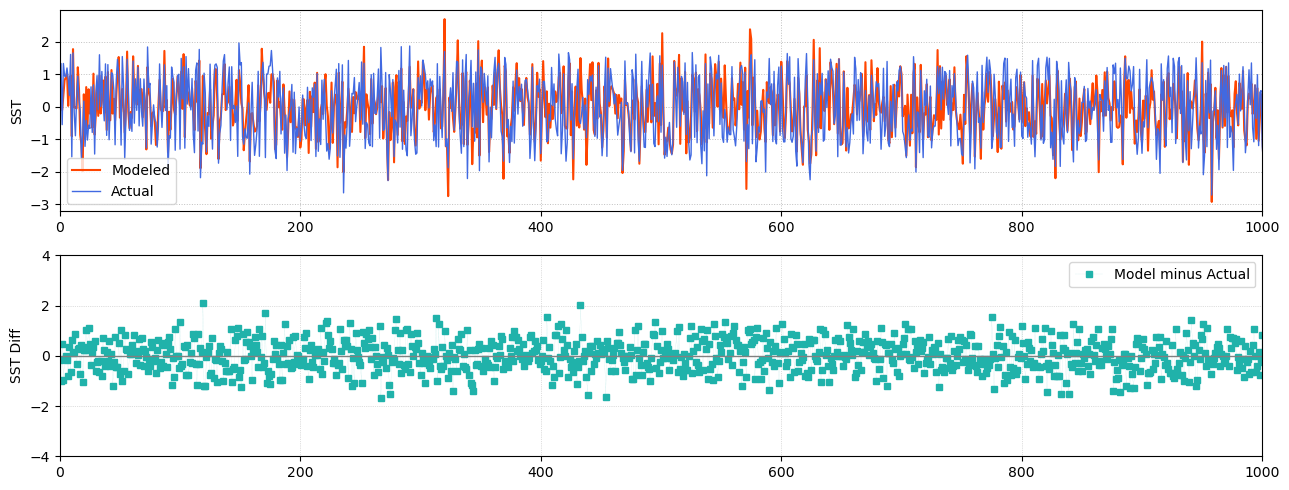

In [9]:
# Plot findings using two subplots (2 rows, 1 column)
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (13, 5))

# Plot Actual and Modeled SST values
ax[0].plot(svr_df.index, svr_df['Modeled'],linestyle='-', c='orangered', linewidth=1.5, label='Modeled')
ax[0].plot(svr_df.index, svr_df['Actual'], linestyle='-', c='royalblue', linewidth=1.0, label='Actual')
# Set the x and y axes
ax[0].set_xlim(0, 1000)  
#ax[0].set_ylim(22,32)
# Format your line plot
ax[0].grid(True, color='silver', linestyle=':', linewidth=0.7)
ax[0].set_ylabel('SST')
ax[0].legend()

# Plot SST_diff values
ax[1].plot(svr_df.index, svr_df['SST_diff'], linestyle=':', linewidth = 0.1, marker = 's', markersize = 5, 
           color = 'lightseagreen', label = 'Model minus Actual')
# Set the x and y axes
ax[1].set_xlim(0, 1000)  
ax[1].set_ylim(-4, 4)
# Add thick line at 0 to highlight differences in SST
ax[1].axhline(y = 0, color = 'grey', linewidth = 1.0)
# Format your line plot
ax[1].grid(True, color='silver', linestyle=':', linewidth = 0.5)
ax[1].set_ylabel('SST Diff')
ax[1].legend()

# Adjust layout to prevent overlapping elements
plt.tight_layout()
plt.show()

### Metrics for Multivariate Regression: `R2` and `RMSE`

In [10]:
# R², MSE, RMSE for Support Vector
r2  = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred, squared = False)
rmse= np.sqrt(mse)

# Print output
print(f"Scaled SV Regressor R²  : {r2:.2f}" )
print(f"Scaled SV Regressor MSE : {mse:.2f}")
print(f"Scaled SV Regressor RMSE: {rmse:.2f}")

Scaled SV Regressor R²  : 0.62
Scaled SV Regressor MSE : 0.62
Scaled SV Regressor RMSE: 0.79


In [11]:
# Convert predictions back to the original scale for interpretation:
# Inverse-transform scaled test target and predictions to original scale
y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# R²,MSE, RMSE for original (unscaled) data
r2_orig  = r2_score(y_test_orig, y_pred_orig)
mse_orig = mean_squared_error(y_test_orig, y_pred_orig)
rmse_orig= np.sqrt(mse_orig)

# Print output
print(f"Unscaled SV Regress R²  : {r2_orig:.2f}"  )
print(f"Unscaled SV Regress MSE : {mse_orig:.2f}" )
print(f"Unscaled SV Regress RMSE: {rmse_orig:.2f}")

Unscaled SV Regress R²  : 0.62
Unscaled SV Regress MSE : 1.51
Unscaled SV Regress RMSE: 1.23


<div class="alert alert-info" role="alert" 
     style="font-size: 1.8em; font-weight: bold; padding: 15px; margin: 10px 0; text-align: center; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">
    Feature Importance
</div>

### Using all data causes slow run times -- assess feature importance on `subset` (sample) dataset instead.

In [12]:
# Select a random subset of your training data (background dataset) for SHAP:
background = X_train[np.random.choice(X_train.shape[0], 10, replace = False)]

# Create KernelExplainer using model predict function on subset
explainer = shap.KernelExplainer(svr_model.predict, background)

# All training data used as background dataset for KernelExplainer
shap_vals = explainer.shap_values(X_test, nsamples = len(X_train))

# Calculate mean absolute SHAP vals for each feature
shap_importance = np.mean(np.abs(shap_vals), axis = 0)
shap_var_series = pd.Series(shap_importance, index = predictors)

# Create df of vars and their importance
shap_df = pd.DataFrame({
    "Variable": predictors,
    "Mean Absolute SHAP": shap_var_series})

# Sort df so most important vars (features) are at the top
shap_df.sort_values(by = "Mean Absolute SHAP", ascending = False, inplace = True)
print(shap_df)

  0%|          | 0/2082 [00:00<?, ?it/s]

    Variable  Mean Absolute SHAP
SSH      SSH            0.604456
MLD      MLD            0.372329
SSS      SSS            0.179480
Vuo      Vuo            0.046277
Vvo      Vvo            0.040197


### Visualising Feature Importance: `bar plot`

In [13]:
# For plotting SHAP:
# Use the diverging "Spectral" palette for colormap:
cmap = sns.color_palette("Spectral", as_cmap = True)

# Compute normalized ranking for each feature (btwn 0 - 1)
# Note -- shap_df values used to determine relative order:
norm_ranks = shap_df["Mean Absolute SHAP"].rank(pct = True)

# Map each normalized rank to a colour via colourmap:
colors = norm_ranks.apply(lambda x: cmap(x)).tolist()

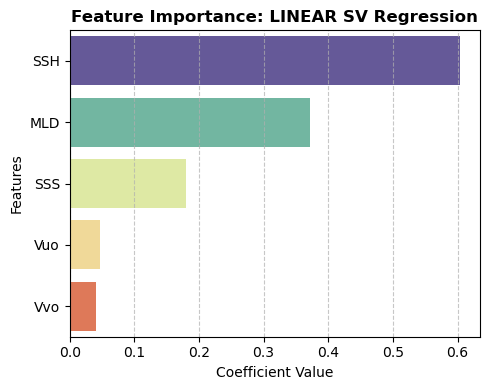

In [14]:
fig2, ax = plt.subplots(1, 1, figsize = (5, 4))

# Create barplot for MV Linear Regression (OLS)
sns.barplot(data = shap_df, x = "Mean Absolute SHAP", y = "Variable", palette = colors)
ax.set_title("Feature Importance: LINEAR SV Regression", fontweight = 'bold')
ax.set_xlabel("Coefficient Value", fontsize = 10)
ax.set_ylabel("Features", fontsize = 10)
ax.grid(axis = 'x', linestyle = '--', alpha = 0.7)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()